# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [3]:
# Drive parameters
noise_amp = 1e-2  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 350  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 20/12/2023 15:54:42: Input parameters:
   - noise:
       - amplitude = 0.010 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 350 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 36
model = NeuralNetwork(
    nnodes,
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=NeuralNetwork.gKT_default,  # S/cm2
    a=1e-4, 
    b=0.5,
    synweight=60e-6, # synaptic weight (S/cm2)
    conrate=.5
)

# Set stimulus start and duration
model.start = start
model.dur = dur

# Set simulation duration
model.tstop = tstop

 20/12/2023 15:54:42: NeuralNetwork(36): created 36 nodes
 20/12/2023 15:54:42: NeuralNetwork(36): connecting 50.0% (630/1260) of candidate node pairs
 20/12/2023 15:54:42: NeuralNetwork(36): setting Q10_rates = 3 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): setting Q10_gNa = 1.4 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): setting Q10_gKd = 4.75 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): setting gKT = 4.898648648648648e-06 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): setting a = 0.0001 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): setting b = 0.5 on all nodes
 20/12/2023 15:54:42: NeuralNetwork(36): initialized


## Simulations

### Test simulation

 20/12/2023 15:54:42: NeuralNetwork(36): removing all connections between nodes
 20/12/2023 15:54:42: NeuralNetwork(36): connecting 20.0% (252/1260) of candidate node pairs
 20/12/2023 15:54:42: NeuralNetwork(36): setting all synaptic weights to 1.00e-05 S/cm2
 20/12/2023 15:54:42: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 2.8% of nodes
 20/12/2023 15:54:42: NeuralNetwork(36): simulating for 350.00 ms


 20/12/2023 15:54:43: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 13.9% of nodes
 20/12/2023 15:54:43: NeuralNetwork(36): simulating for 350.00 ms
 20/12/2023 15:54:43: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 25.0% of nodes
 20/12/2023 15:54:43: NeuralNetwork(36): simulating for 350.00 ms
 20/12/2023 15:54:43: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 36.1% of nodes
 20/12/2023 15:54:43: NeuralNetwork(36): simulating for 350.00 ms
 20/12/2023 15:54:43: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 47.2% of nodes
 20/12/2023 15:54:43: NeuralNetwork(36): simulating for 350.00 ms
 20/12/2023 15:54:43: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 55.6% of nodes
 20/12/2023 15:54:43: NeuralNetwork(36): simulating for 350.00 ms
 20/12/2023 15:54:44: NeuralNetwork(36): setting 150.00 ms stimulus with amplitude 200.00 W/cm2 on 6

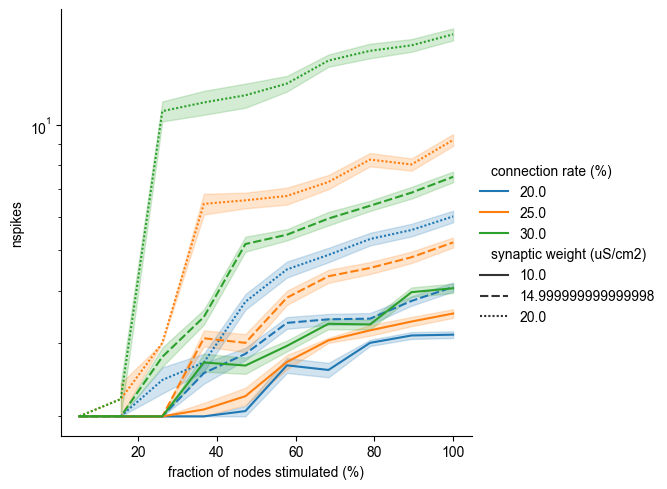

In [5]:
# Set stimulus amplitude
Isppa = 200.  # W/cm2

# Define vectors of connection rates, synaptic weights and stimulated fractions
conrates = np.linspace(0.2, .3, 3)
synweights = np.array([10, 15, 20]) * 1e-6
stimfracs = np.linspace(0.05, 1, 10)

# Initialize nspikes container
nspikes = []

# Sweep connection rates, synaptic weights and stimulated fractions, and compute nspikes
for conrate in conrates:
    model.set_connection_rate(conrate)
    for synweight in synweights:
        model.set_synaptic_weight(synweight)
        for stimfrac in stimfracs:
            model.set_stim(Isppa, fraction=stimfrac)
            data = model.simulate()
            nspikes.append(
                model.compute_metric(data, 'nspikes', inodes='stim'))
nspikes = pd.concat(
    nspikes, 
    axis=0, 
    keys=itertools.product(
        conrates * 1e2, 
        synweights * 1e6, 
        stimfracs * 1e2
    ), 
    names=[
        'connection rate (%)', 
        'synaptic weight (uS/cm2)', 
        'fraction of nodes stimulated (%)'
    ]
)

# Plot average number of spikes in sonicated nodes, as a function of the fraction of stimulated nodes
fg = sns.relplot(
    kind='line',
    data=nspikes.reset_index(), 
    x='fraction of nodes stimulated (%)', 
    y='nspikes',
    hue='connection rate (%)',
    palette='tab10',
    style='synaptic weight (uS/cm2)',
    errorbar='se',
)
fig = fg.fig
fig.axes[0].set_yscale('log')

In [6]:
# # Set connection rate and synaptic weight
# model.set_mech_param(a=1e-4)
# model.set_connection_rate(.5)
# model.set_synaptic_weight(model.g_RS_RS)

# # Define vector of stimulated fractions
# stimfracs = np.linspace(0.1, .9, 9).round(2)

# myrange = sqrtspace(1, 2 * Imax, 20)

# # Sweep stimulated fractions, and compute nspikes over Isppa range
# readouts = ['stim', 'nostim']
# nspikes = []
# for stimfrac in stimfracs:
#     stimdist = model.get_stimdist_vector(kind=stimfrac)
#     data = model.run_stim_sweep(myrange, stimdist)
#     for readout in readouts:
#         nspikes.append(
#             model.compute_metric(data, 'nspikes', inodes=readout))
# nspikes = pd.concat(
#     nspikes, 
#     axis=0, 
#     keys=itertools.product(
#         stimfracs * 1e2, 
#         readouts
#     ), 
#     names=[
#         'fraction of nodes stimulated (%)',
#         'readout'
#     ]
# )

# fg = sns.relplot(
#     kind='line',
#     data=nspikes.reset_index(), 
#     x=model.ISPPA_KEY,
#     y='nspikes',
#     hue='fraction of nodes stimulated (%)', 
#     style='readout',
#     errorbar='se',
#     legend='full',
# )
# # fig = fg.fig
# # fig.axes[0].set_yscale('log')

 20/12/2023 17:19:58: NeuralNetwork(36): removing all connections between nodes
 20/12/2023 17:19:58: NeuralNetwork(36): connecting 6.0% (76/1260) of candidate node pairs
 20/12/2023 17:19:58: NeuralNetwork(36): setting all synaptic weights to 1.00e-04 S/cm2
 20/12/2023 17:19:58: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


 20/12/2023 17:20:01: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:00<00:00, 15.46it/s]


 20/12/2023 17:20:02: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:00<00:00, 15.17it/s]


 20/12/2023 17:20:03: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


 20/12/2023 17:20:05: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:00<00:00, 16.21it/s]


 20/12/2023 17:20:06: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


 20/12/2023 17:20:17: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


 20/12/2023 17:20:23: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


 20/12/2023 17:20:34: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


 20/12/2023 17:20:42: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


 20/12/2023 17:20:55: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


 20/12/2023 17:21:04: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


 20/12/2023 17:21:16: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


 20/12/2023 17:21:27: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


 20/12/2023 17:21:38: NeuralNetwork(36): running simulation sweep across 14 stimulus intensities


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


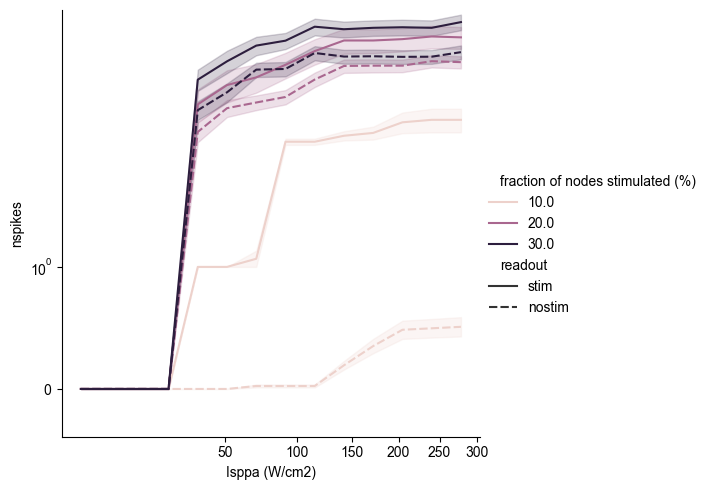

In [19]:
# Set connection rate and synaptic weight
model.set_connection_rate(.06)  # from Vierling-Claassen et al. 2010
model.set_synaptic_weight(1e-4)  # from Vierling-Claassen et al. 2010 (S/cm2)

# Set stimulus sensitivity
model.set_mech_param(a=1e-4)

# Define vector of stimulated fractions
stimfracs = np.linspace(.1, .3, 3).round(2)

# Sweep stimulated fractions, and compute nspikes over Isppa range
readouts = ['stim', 'nostim']
nspikes = []
nreps = 5
ireps = np.array(range(nreps))
for stimfrac in stimfracs:
    for irep in ireps:
        stimdist = model.get_stimdist_vector(kind=stimfrac)
        data = model.run_stim_sweep(Isppa_range[1:], stimdist)
        for readout in readouts:
            nspikes.append(
                model.compute_metric(data, 'nspikes', inodes=readout))
nspikes = pd.concat(
    nspikes, 
    axis=0, 
    keys=itertools.product(
        stimfracs * 1e2, 
        ireps,
        readouts
    ), 
    names=[
        'fraction of nodes stimulated (%)',
        'rep',
        'readout'
    ]
)

fg = sns.relplot(
    kind='line',
    data=nspikes.reset_index(), 
    x=model.ISPPA_KEY,
    y='nspikes',
    hue='fraction of nodes stimulated (%)', 
    style='readout',
    errorbar='se',
    legend='full',
)
ax = fg.fig.axes[0]
model.set_ax_scale(ax, 'x', 'sqrt')
model.set_ax_scale(ax, 'y', 'symlog')

## Log completion

In [8]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 20/12/2023 15:56:28: notebook completed in 0:01:45.366383
